In [1]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
# Path to your Excel file
file_path = '/Users/abbiemaemoto/Desktop/playlist data.xlsx'

# Read all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(all_sheets.values())

# Displaying the first few rows of the dataframe
print(combined_df.head())

                              Track URI        Track Name  \
0  spotify:track:0L6UCE1Y0KX3MF2AtxlntI           Fragile   
1  spotify:track:7vGuf3Y35N4wmASOKLUVVU           Silence   
2  spotify:track:4V3VshJLUTCIWa77YiAkvM            Winter   
3  spotify:track:2QCndYqRherBtKjBpyySC6          Sober Up   
4  spotify:track:2pyjbGTpJCPjMYwCbdymiF  Dazed & Confused   

                                       Artist URI(s)      Artist Name(s)  \
0  spotify:artist:23fqKkggKUBHNkbKtXEls4, spotify...      Kygo, Labrinth   
1  spotify:artist:64KEffDW9EtZ1y2vBYgq8T, spotify...  Marshmello, Khalid   
2              spotify:artist:6LuN9FCkKOj5PcnpouEgny              Khalid   
3  spotify:artist:6s22t5Y3prQHyaHWUN1R1C, spotify...   AJR, Rivers Cuomo   
4              spotify:artist:5xkAtLTf309LAGZTbvULBn                Ruel   

                              Album URI        Album Name  \
0  spotify:album:1rQwHiQkppiCVBgNBOsFii           Fragile   
1  spotify:album:2bw00gRKNKbTFOqCkohbSh           Sile

Playlist
1      99
2      33
3      50
4     165
5     101
6      62
7      45
8     185
9     146
10    186
11     67
12    179
Name: count, dtype: int64


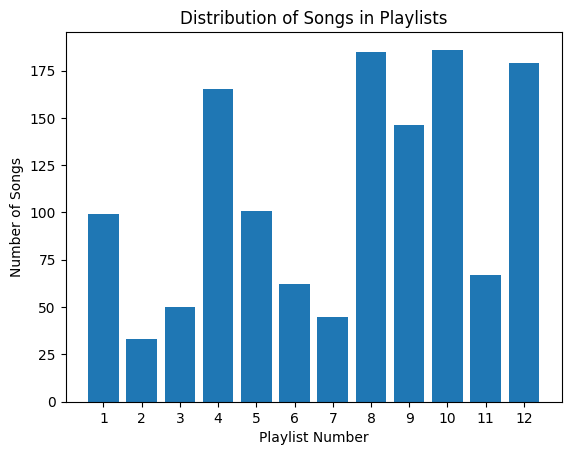

In [17]:
import matplotlib.pyplot as plt
playlist_counts = combined_df['Playlist'].value_counts().sort_index()
print(playlist_counts)
plt.bar(playlist_counts.index, playlist_counts.values)
plt.xlabel('Playlist Number')
plt.ylabel('Number of Songs')
plt.title('Distribution of Songs in Playlists')
plt.xticks(range(1, 13))  # Assuming playlist numbers range from 1 to 12
plt.show()

In [18]:
#Target variable -->train
y = combined_df['Playlist']

#Model features
X = combined_df.drop([
    "Playlist",
    "Track URI", 
    "Artist URI(s)",
    "Album URI",
    "Album Artist URI(s)",
    "Album Artist Name(s)",
    "Album Release Date",
    "Album Image URL",
    "Disc Number",
    "Track Number",
    "Track Duration (ms)",
    "Track Preview URL",
    "ISRC",
    "Added By",
    "Added At"
], axis=1)

cat_cols = ["Track Name", "Artist Name(s)", "Album Name"]
for col in cat_cols:
    X[col] = X[col].astype("str")

X["Explicit"] = X["Explicit"].astype(int)

print(X.head())

         Track Name      Artist Name(s)        Album Name  Explicit  \
0           Fragile      Kygo, Labrinth           Fragile         0   
1           Silence  Marshmello, Khalid           Silence         0   
2            Winter              Khalid     American Teen         0   
3          Sober Up   AJR, Rivers Cuomo         The Click         0   
4  Dazed & Confused                Ruel  Dazed & Confused         0   

   Popularity  
0           1  
1          83  
2          54  
3           0  
4          61  


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_track = TfidfVectorizer()
vectorizer_artist = TfidfVectorizer()
vectorizer_album = TfidfVectorizer()
track_tfidf = vectorizer_track.fit_transform(X['Track Name']).toarray()
artist_tfidf = vectorizer_artist.fit_transform(X['Artist Name(s)']).toarray()
album_tfidf = vectorizer_album.fit_transform(X['Album Name']).toarray()

In [20]:
features = pd.concat([pd.DataFrame(track_tfidf), pd.DataFrame(artist_tfidf),pd.DataFrame(album_tfidf)], axis=1)
features['Explicit'] = X['Explicit'].reset_index(drop=True)
features['Popularity'] = X['Popularity'].reset_index(drop=True)
features.columns = features.columns.astype(str)

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
y = [[label] for label in y]
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(y)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [23]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Initialize base classifier
rf = RandomForestClassifier(random_state=42)
# Initialize MultiOutputClassifier
multi_target_rf = MultiOutputClassifier(rf, n_jobs=-1)
# Train the model
multi_target_rf.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1)

In [29]:
from sklearn.metrics import classification_report
y_pred = multi_target_rf.predict(X_test)

In [30]:
# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
print(classification_report(y_test, y_pred))
auc_val = roc_auc_score(y_test, y_pred, average='macro')
print("AUC ROC value :", auc_val) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10
           3       0.56      0.15      0.24        33
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         9
           7       0.85      0.30      0.44        37
           8       0.75      0.21      0.32        29
           9       0.69      0.24      0.36        37
          10       1.00      0.14      0.25        14
          11       0.64      0.25      0.36        36

   micro avg       0.61      0.16      0.25       264
   macro avg       0.37      0.11      0.16       264
weighted avg       0.51      0.16      0.24       264
 samples avg       0.16      0.16      0.16       264

AUC ROC value : 0.5490553879462171


/Users/abbiemaemoto/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/abbiemaemoto/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
import numpy as np
new_songs = [
    {'Track Name': 'Winter', 'Artist Name(s)': 'Khalid', 'Album Name': 'American Teen', 'Explicit': 0, 'Popularity': 54},
    {'Track Name': 'Ophelia', 'Artist Name(s)': 'The Lumineers', 'Album Name': 'Cleopatra', 'Explicit': 0, 'Popularity': 77},
    {'Track Name': 'We Find Love', 'Artist Name(s)': 'Daniel Caesar', 'Album Name': 'Freudian', 'Explicit': 0, 'Popularity': 66},
    {'Track Name': 'Pata Pata', 'Artist Name(s)': 'Miriam Makeba', 'Album Name': 'Reflections', 'Explicit': 0, 'Popularity': 0},
    {'Track Name': 'Dull', 'Artist Name(s)': 'Asake', 'Album Name': 'Mr. Money With The Vibe', 'Explicit': 0, 'Popularity': 69},
]

# Preprocess new songs
new_track_tfidf = vectorizer_track.transform([song['Track Name'] for song in new_songs]).toarray()
new_artist_tfidf = vectorizer_artist.transform([song['Artist Name(s)'] for song in new_songs]).toarray()
new_album_tfidf = vectorizer_album.transform([song['Album Name'] for song in new_songs]).toarray()

new_explicit = np.array([song['Explicit'] for song in new_songs]).reshape(-1, 1)
new_popularity = np.array([song['Popularity'] for song in new_songs]).reshape(-1, 1)

new_features = np.hstack([new_track_tfidf, new_artist_tfidf, new_album_tfidf, new_explicit, new_popularity])

# Predict playlists
new_predictions = multi_target_rf.predict(new_features)

# Aggregate predictions
# Sum the predictions to see which playlists are most common
playlist_counts = np.sum(new_predictions, axis=0)
predicted_playlists = mlb.inverse_transform((playlist_counts > 1).reshape(1, -1))

print("Predicted Playlists for the new songs:")
print(predicted_playlists)

Predicted Playlists for the new songs:
[(6,)]


/Users/abbiemaemoto/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/abbiemaemoto/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/abbiemaemoto/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/abbiemaemoto/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/abbiemaemoto/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with featur

In [36]:
import random
pred_songs = []
for i in range(16):
    curr_playlist = random.choice(predicted_playlists[0])
    new_song = X[combined_df['Playlist'] == curr_playlist]
    songs = new_song.values.tolist()
    random_song = random.choice(songs)
    title = random_song[0]
    pred_songs.append(title)
print("Here are songs recommended for your new playlist: ", pred_songs)


Here are songs recommended for your new playlist:  ['Weekends', 'Where the Water Clears the Illusion', 'Pyramids', 'Dull', 'Falling In Love', 'Grrrls', 'Gonna Get Over You', 'Secrets (Your Fire)', 'killer', 'Give It To Me Baby', 'Ever Again', 'Poem Of Dead Song', 'candy grapes (feat. Steve Lacy)', 'Ever Again', 'Caught', 'Dull']
